In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import shapiro
import itertools
from sklearn.ensemble import RandomForestRegressor
from prophet import Prophet
import matplotlib.patches as mpatches
import plotly.graph_objects as go
import geopandas as gpd
import plotly.express as px

In [7]:
df = pd.read_csv("GlobalTemperatures.csv")
df['dt'] = pd.to_datetime(df['dt'], format='%Y-%m-%d')
df.set_index('dt', inplace=True)

In [9]:
non_nan_years = {}
for column in df.columns:
    first_non_nan_index = df[column].first_valid_index()
    if first_non_nan_index is not None:
        non_nan_years[column] = first_non_nan_index.year

print(non_nan_years)

{'LandAverageTemperature': 1750, 'LandAverageTemperatureUncertainty': 1750, 'LandMaxTemperature': 1850, 'LandMaxTemperatureUncertainty': 1850, 'LandMinTemperature': 1850, 'LandMinTemperatureUncertainty': 1850, 'LandAndOceanAverageTemperature': 1850, 'LandAndOceanAverageTemperatureUncertainty': 1850}


In [11]:
width = 150
pd.set_option('display.width', width)
np.set_printoptions(linewidth=width)
pd.set_option('display.max_columns', 10)

In [13]:
df_filtered = df[df.index.year >= 1850]
missing_values = df_filtered.isna().sum()
print(missing_values)

LandAverageTemperature                       0
LandAverageTemperatureUncertainty            0
LandMaxTemperature                           0
LandMaxTemperatureUncertainty                0
LandMinTemperature                           0
LandMinTemperatureUncertainty                0
LandAndOceanAverageTemperature               0
LandAndOceanAverageTemperatureUncertainty    0
dtype: int64


In [15]:
descriptive_stats = df_filtered.describe()
print(descriptive_stats)

       LandAverageTemperature  LandAverageTemperatureUncertainty  LandMaxTemperature  LandMaxTemperatureUncertainty  LandMinTemperature  \
count             1992.000000                        1992.000000         1992.000000                    1992.000000         1992.000000   
mean                 8.571583                           0.276663           14.350601                       0.479782            2.743595   
std                  4.263193                           0.224030            4.309579                       0.583203            4.155835   
min                  0.404000                           0.034000            5.900000                       0.044000           -5.407000   
25%                  4.430000                           0.099750           10.212000                       0.142000           -1.334500   
50%                  8.850500                           0.230000           14.760000                       0.252000            2.949500   
75%                 12.8585

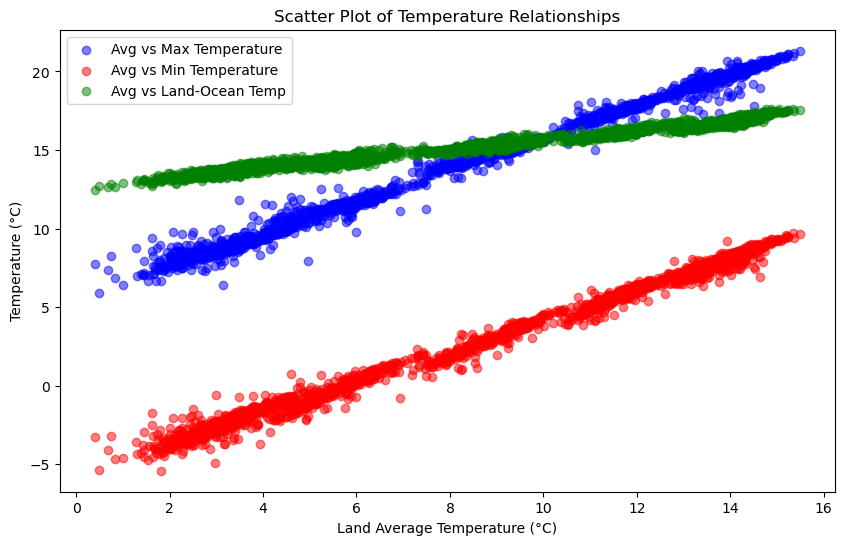

In [17]:
plt.figure(figsize=(10, 6))
plt.scatter(df['LandAverageTemperature'], df['LandMaxTemperature'], alpha=0.5, color='blue', label='Avg vs Max Temperature')
plt.scatter(df['LandAverageTemperature'], df['LandMinTemperature'], alpha=0.5, color='red', label='Avg vs Min Temperature')
plt.scatter(df['LandAverageTemperature'], df['LandAndOceanAverageTemperature'], alpha=0.5, color='green', label='Avg vs Land-Ocean Temp')
plt.title('Scatter Plot of Temperature Relationships')
plt.xlabel('Land Average Temperature (°C)')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

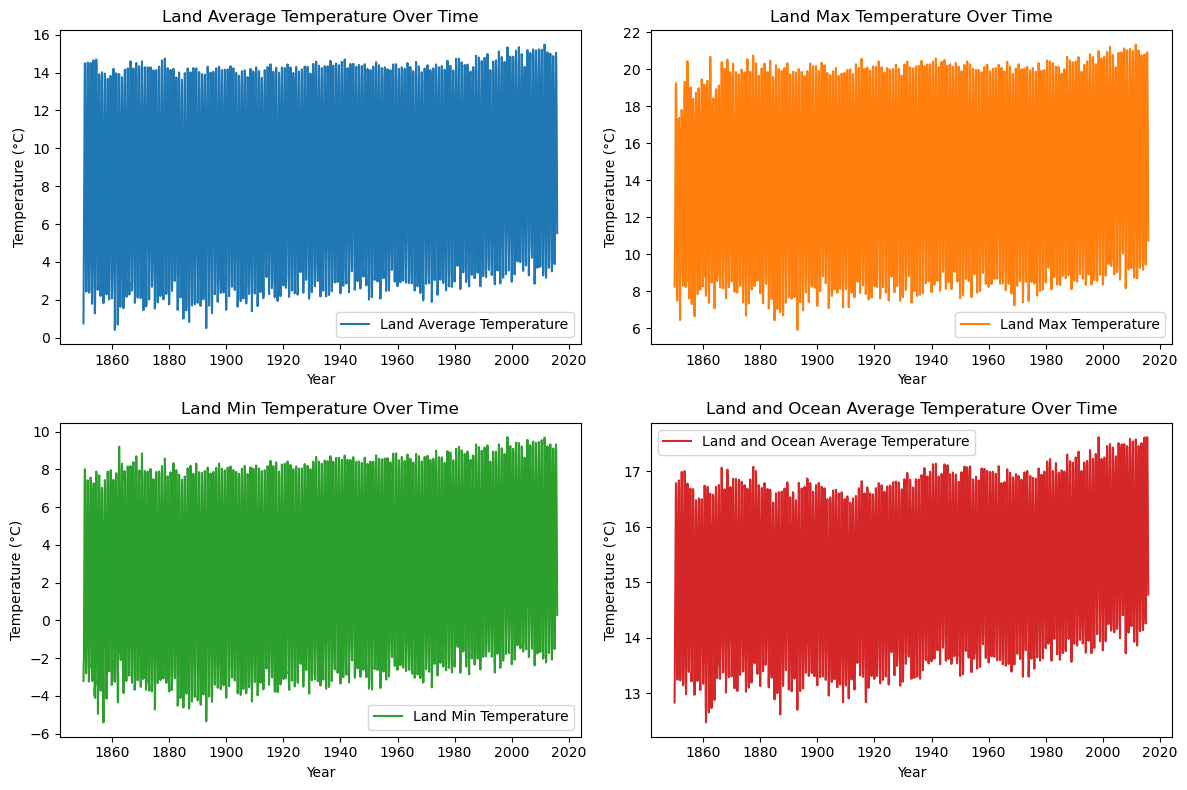

In [19]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(df_filtered.index, df_filtered['LandAverageTemperature'], label='Land Average Temperature', color='tab:blue')
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.title('Land Average Temperature Over Time')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(df_filtered.index, df_filtered['LandMaxTemperature'], label='Land Max Temperature', color='tab:orange')
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.title('Land Max Temperature Over Time')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(df_filtered.index, df_filtered['LandMinTemperature'], label='Land Min Temperature', color='tab:green')
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.title('Land Min Temperature Over Time')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(df_filtered.index, df_filtered['LandAndOceanAverageTemperature'], label='Land and Ocean Average Temperature', color='tab:red')
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.title('Land and Ocean Average Temperature Over Time')
plt.legend()

plt.tight_layout()
plt.show()

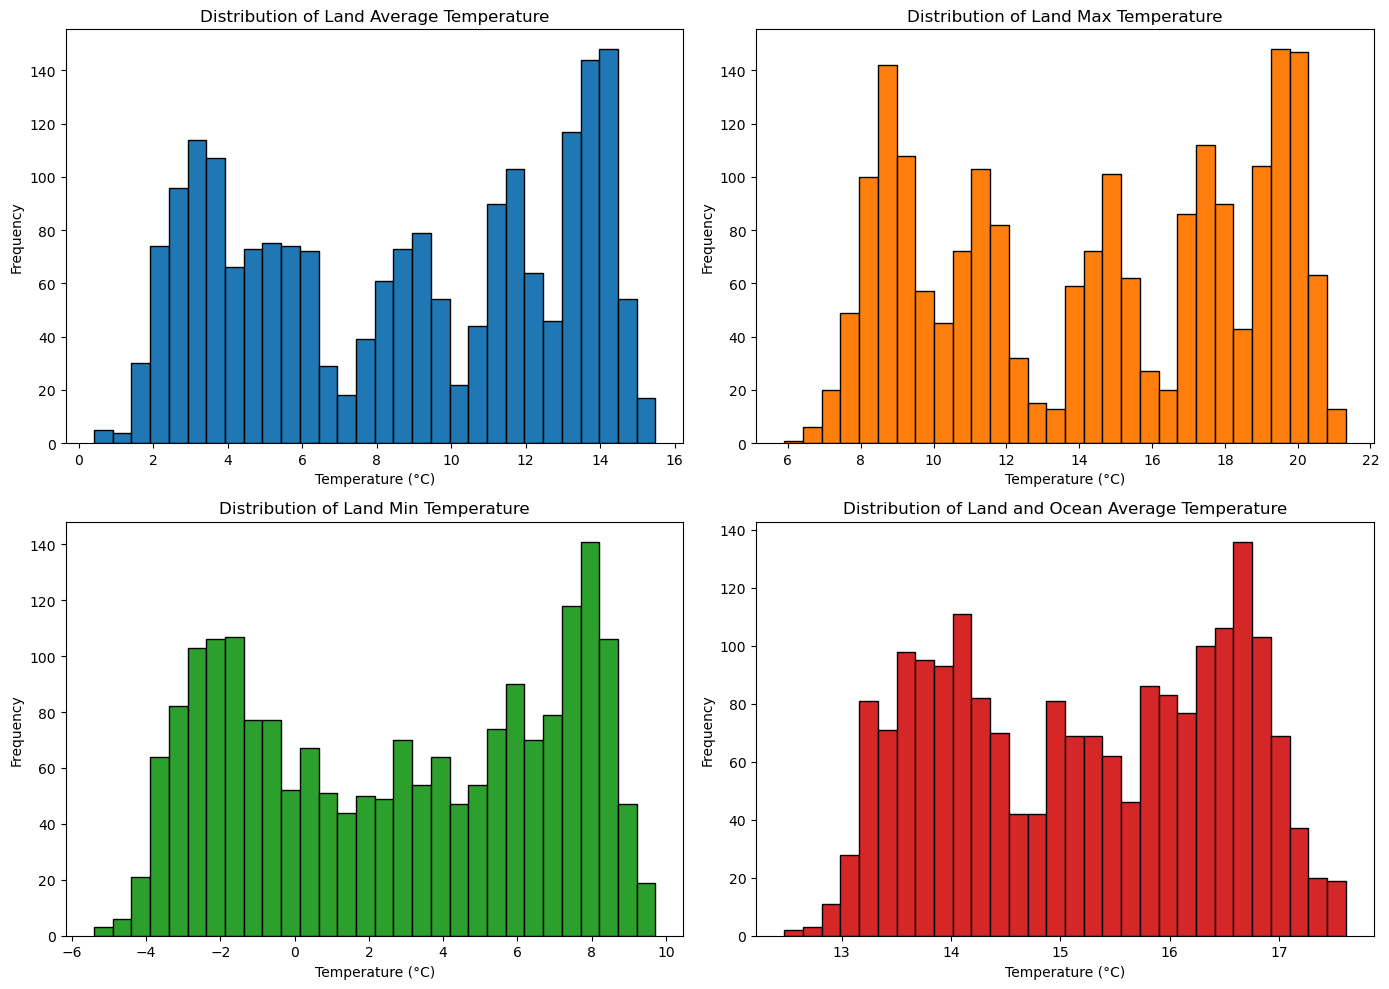

In [20]:
plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
plt.hist(df_filtered['LandAverageTemperature'], bins=30, color='tab:blue', edgecolor='black')
plt.xlabel('Temperature (°C)')
plt.ylabel('Frequency')
plt.title('Distribution of Land Average Temperature')

plt.subplot(2, 2, 2)
plt.hist(df_filtered['LandMaxTemperature'], bins=30, color='tab:orange', edgecolor='black')
plt.xlabel('Temperature (°C)')
plt.ylabel('Frequency')
plt.title('Distribution of Land Max Temperature')

plt.subplot(2, 2, 3)
plt.hist(df_filtered['LandMinTemperature'], bins=30, color='tab:green', edgecolor='black')
plt.xlabel('Temperature (°C)')
plt.ylabel('Frequency')
plt.title('Distribution of Land Min Temperature')

plt.subplot(2, 2, 4)
plt.hist(df_filtered['LandAndOceanAverageTemperature'], bins=30, color='tab:red', edgecolor='black')
plt.xlabel('Temperature (°C)')
plt.ylabel('Frequency')
plt.title('Distribution of Land and Ocean Average Temperature')

plt.tight_layout()
plt.show()

In [23]:
df1 = pd.read_csv("GlobalLandTemperaturesByCountry.csv")
missing_values = df1.isnull().sum()
descriptive_stats = df1['AverageTemperature'].describe()

In [25]:
print(missing_values)
print(descriptive_stats)

dt                                   0
AverageTemperature               32651
AverageTemperatureUncertainty    31912
Country                              0
dtype: int64
count    544811.000000
mean         17.193354
std          10.953966
min         -37.658000
25%          10.025000
50%          20.901000
75%          25.814000
max          38.842000
Name: AverageTemperature, dtype: float64


In [27]:
df1['AverageTemperature'].fillna(method='ffill')
df1['AverageTemperatureUncertainty'].fillna(method='ffill')
df1['dt'] = pd.to_datetime(df1['dt'])

C:\Users\stepn\AppData\Local\Temp\ipykernel_26668\3215919114.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df1['AverageTemperature'].fillna(method='ffill')
C:\Users\stepn\AppData\Local\Temp\ipykernel_26668\3215919114.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df1['AverageTemperatureUncertainty'].fillna(method='ffill')


In [29]:
df1['Year'] = df1['dt'].dt.year
yearly_average_temperature = df1.groupby('Year')['AverageTemperature'].mean().reset_index()
country_avg_temp = df1.groupby('Country')['AverageTemperature'].mean().reset_index()

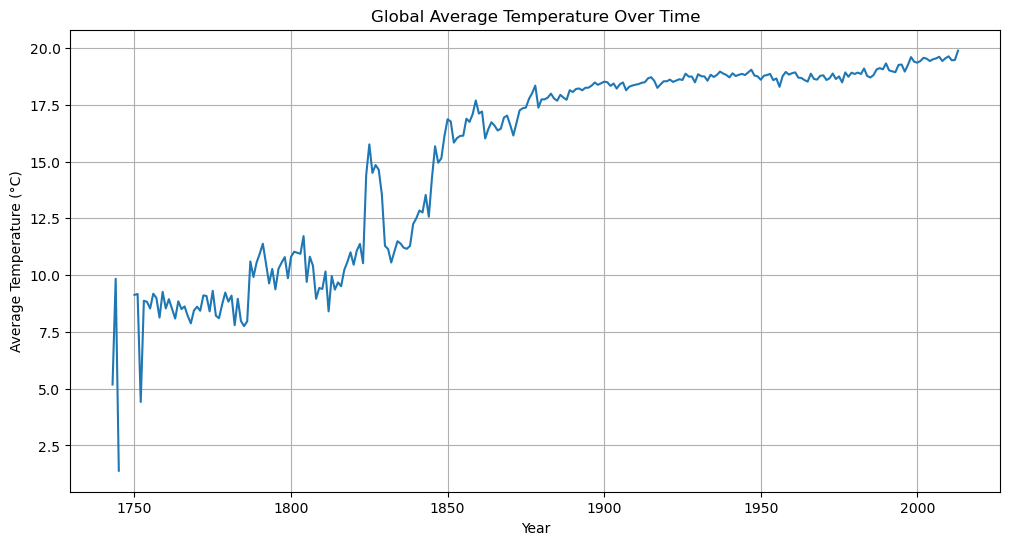

In [31]:
plt.figure(figsize=(12, 6))
plt.plot(yearly_average_temperature['Year'], yearly_average_temperature['AverageTemperature'], label='Average Temperature')
plt.title('Global Average Temperature Over Time')
plt.xlabel('Year')
plt.ylabel('Average Temperature (°C)')
plt.grid(True)
plt.show()

In [35]:
older_period = df1[df1['Year'] < 1950]
recent_period = df1[df1['Year'] > 2000]

older_avg_temp = older_period['AverageTemperature'].mean()
recent_avg_temp = recent_period['AverageTemperature'].mean()

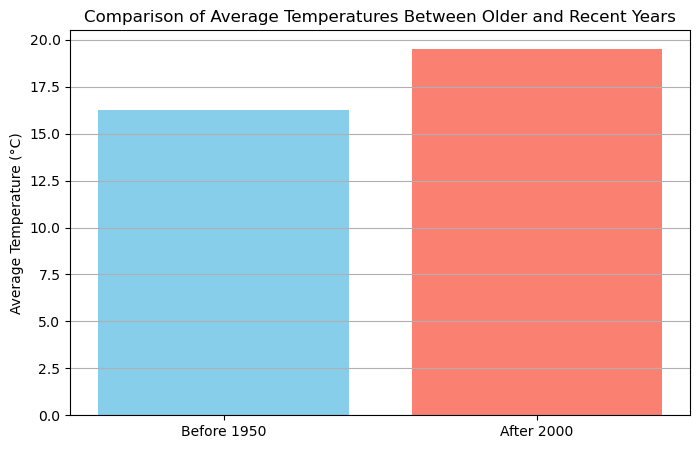

16.266863060705077
19.52888827604945


In [37]:
plt.figure(figsize=(8, 5))
plt.bar(['Before 1950', 'After 2000'], [older_avg_temp, recent_avg_temp], color=['skyblue', 'salmon'])
plt.title('Comparison of Average Temperatures Between Older and Recent Years')
plt.ylabel('Average Temperature (°C)')
plt.grid(axis='y')
plt.show()

print(older_avg_temp)
print(recent_avg_temp)

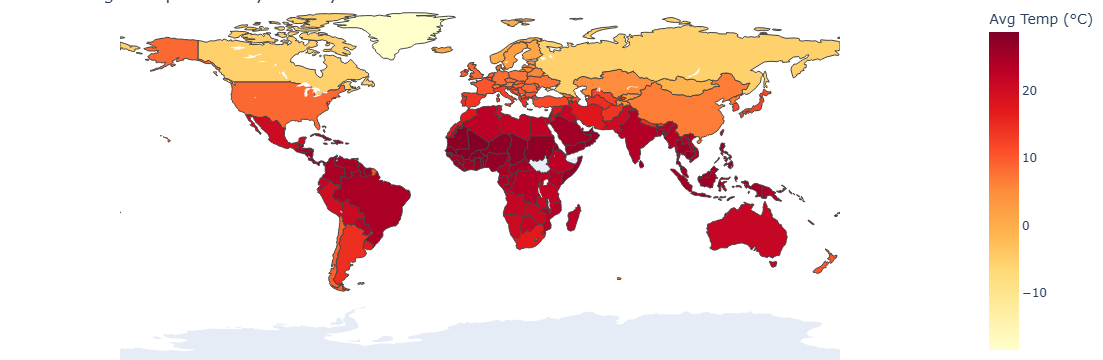

In [39]:
fig = px.choropleth(
    country_avg_temp,
    locations='Country',
    locationmode='country names',
    color='AverageTemperature',
    hover_name='Country',
    color_continuous_scale='YlOrRd',
    title='Average Temperature by Country',
    labels={'AverageTemperature': 'Avg Temp (°C)'}
)

fig.update_layout(
    geo=dict(showframe=False, showcoastlines=False, projection_type='equirectangular'),
    margin={"r":0,"t":0,"l":0,"b":0}
)

# Show the plot
fig.show()

In [41]:
temperature_series = df_filtered['LandAverageTemperature'].dropna()

In [43]:
exog_vars = df_filtered[['LandMaxTemperature', 'LandMinTemperature']].dropna()
exog_vars = exog_vars.loc[temperature_series.index]

In [45]:
train_end = '2014-12-01'
test_start = '2015-01-01'
test_end = '2015-12-01'

In [47]:
train_data = temperature_series[:train_end]
test_data = temperature_series[test_start:test_end]
train_exog = exog_vars[:train_end]
test_exog = exog_vars[test_start:test_end]

In [49]:
def create_lag_features(series, exog, lags):
    lag_features = pd.DataFrame(index=series.index)
    for lag in range(1, lags + 1):
        lag_features[f'lag_{lag}'] = series.shift(lag)
    for var in exog.columns:
        for lag in range(1, lags + 1):
            lag_features[f'{var}_lag_{lag}'] = exog[var].shift(lag)
    lag_features['target'] = series
    return lag_features.dropna()

In [51]:
sarima_model = SARIMAX(train_data, exog=train_exog, order=(2, 1, 2), seasonal_order=(0, 1, 1, 12))
sarima_result = sarima_model.fit(disp=False)
sarima_forecast = sarima_result.get_forecast(steps=12, exog=test_exog)
sarima_forecast_index = pd.date_range(start=test_start, periods=12, freq='MS')
sarima_forecast_series = pd.Series(sarima_forecast.predicted_mean, index=sarima_forecast_index)

C:\Users\stepn\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

C:\Users\stepn\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

C:\Users\stepn\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [53]:
lags = 12
data = create_lag_features(temperature_series, exog_vars, lags)

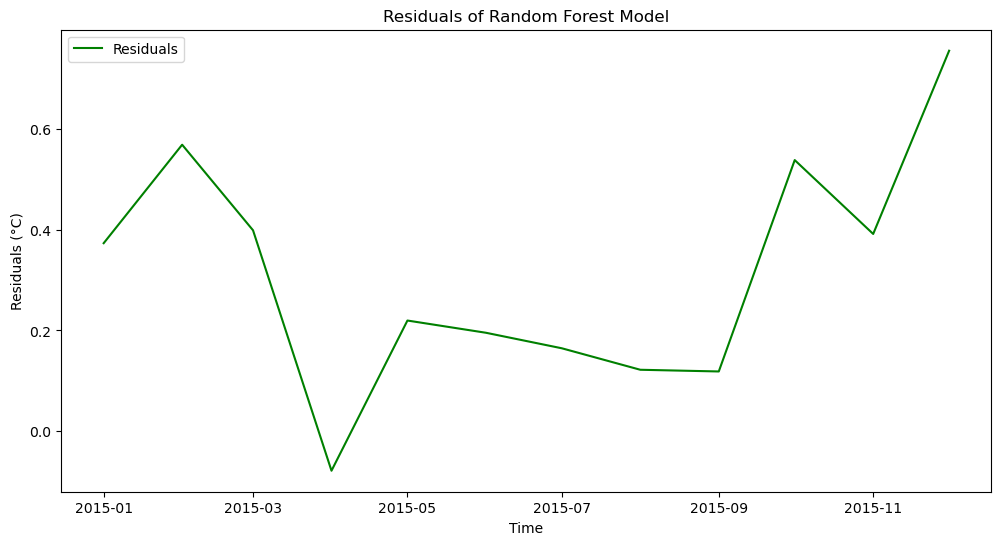

In [57]:
train_data_rf = data[:train_end]
test_data_rf = data[test_start:test_end]

X_train_rf = train_data_rf.drop(columns='target')
y_train_rf = train_data_rf['target']
X_test_rf = test_data_rf.drop(columns='target')
y_test_rf = test_data_rf['target']

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_rf, y_train_rf)

y_pred_rf = rf_model.predict(X_test_rf)

residuals_rf = df['LandAverageTemperature'].tail(len(y_pred_rf)) - y_pred_rf

plt.figure(figsize=(12, 6))
plt.plot(df.index[-len(y_pred_rf):], residuals_rf, label='Residuals', color='green')
plt.title('Residuals of Random Forest Model')
plt.xlabel('Time')
plt.ylabel('Residuals (°C)')
plt.legend()
plt.show()

19:26:50 - cmdstanpy - INFO - Chain [1] start processing
19:26:50 - cmdstanpy - INFO - Chain [1] done processing


Test data dates: 2015-01-01 00:00:00 - 2015-12-01 00:00:00
Forecast series dates: 2015-01-01 00:00:00 - 2015-12-01 00:00:00
12 12


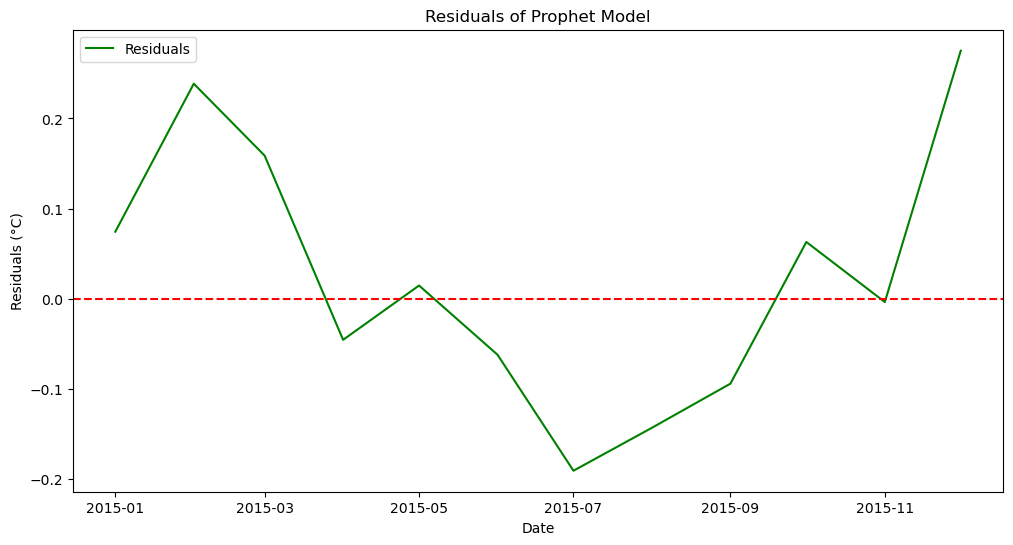

In [59]:
prophet_data = temperature_series.reset_index()
prophet_data.rename(columns={'dt': 'ds', 'LandAverageTemperature': 'y'}, inplace=True)

exog_vars_reset = exog_vars.reset_index()
exog_vars_reset.rename(columns={'dt': 'ds'}, inplace=True)

prophet_data = pd.merge(prophet_data, exog_vars_reset, on='ds')

train_data_prophet = prophet_data[prophet_data['ds'] <= train_end]
test_data_prophet = prophet_data[(prophet_data['ds'] >= test_start) & (prophet_data['ds'] <= test_end)]

prophet_model = Prophet()
prophet_model.add_regressor('LandMaxTemperature')
prophet_model.add_regressor('LandMinTemperature')
prophet_model.fit(train_data_prophet)
future = prophet_model.make_future_dataframe(periods=12, freq='MS')
future = pd.merge(future, exog_vars_reset, on='ds')
forecast = prophet_model.predict(future)
prophet_forecast_series = forecast.set_index('ds')['yhat'][test_start:test_end]


print("Test data dates:", test_data_prophet['ds'].min(), "-", test_data_prophet['ds'].max())
print("Forecast series dates:", prophet_forecast_series.index.min(), "-", prophet_forecast_series.index.max())
prophet_forecast_series = prophet_forecast_series.loc[test_data_prophet['ds'].min():test_data_prophet['ds'].max()]

print(len(test_data_prophet['ds']), len(prophet_forecast_series))
prophet_residuals = test_data_prophet['y'].values - prophet_forecast_series.values

plt.figure(figsize=(12, 6))
plt.plot(test_data_prophet['ds'], prophet_residuals, label='Residuals', color='green')
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals of Prophet Model')
plt.xlabel('Date')
plt.ylabel('Residuals (°C)')
plt.legend()
plt.show()

In [61]:
metrics = {
    'Model': ['SARIMA', 'Random Forest', 'Prophet'],
    'MAE': [
        mean_absolute_error(test_data, sarima_forecast_series),
        mean_absolute_error(y_test_rf, y_pred_rf),
        mean_absolute_error(test_data_prophet['y'], prophet_forecast_series)
    ],
    'MSE': [
        mean_squared_error(test_data, sarima_forecast_series),
        mean_squared_error(y_test_rf, y_pred_rf),
        mean_squared_error(test_data_prophet['y'], prophet_forecast_series)
    ],
    'RMSE': [
        np.sqrt(mean_squared_error(test_data, sarima_forecast_series)),
        np.sqrt(mean_squared_error(y_test_rf, y_pred_rf)),
        np.sqrt(mean_squared_error(test_data_prophet['y'], prophet_forecast_series))
    ],
    'R²': [
        r2_score(test_data, sarima_forecast_series),
        r2_score(y_test_rf, y_pred_rf),
        r2_score(test_data_prophet['y'], prophet_forecast_series)
    ]
}

metrics_df = pd.DataFrame(metrics)

In [63]:
print("\nComparison of SARIMA, Random Forest, and Prophet Models:")
print(metrics_df)


Comparison of SARIMA, Random Forest, and Prophet Models:
           Model       MAE       MSE      RMSE        R²
0         SARIMA  0.099627  0.017148  0.130951  0.998898
1  Random Forest  0.327264  0.148886  0.385857  0.990433
2        Prophet  0.113699  0.019948  0.141238  0.998718


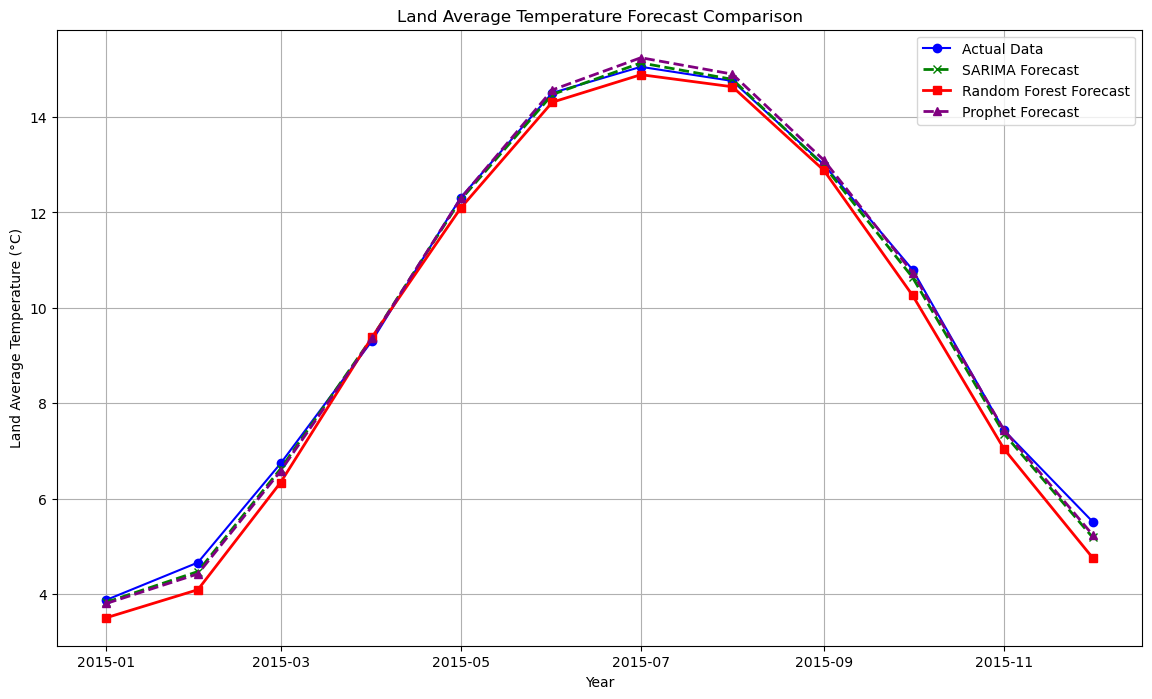

In [65]:
plt.figure(figsize=(14, 8))
plt.plot(test_data.index, test_data, label='Actual Data', color='blue', linestyle='-', marker='o')
plt.plot(sarima_forecast_series.index, sarima_forecast_series, label='SARIMA Forecast', color='green', linestyle='--', marker='x', linewidth=2)
plt.plot(y_test_rf.index, y_pred_rf, label='Random Forest Forecast', color='red', linestyle='-', marker='s', linewidth=2)
plt.plot(prophet_forecast_series.index, prophet_forecast_series, label='Prophet Forecast', color='purple', linestyle='--', marker='^', linewidth=2)

plt.xlabel('Year')
plt.ylabel('Land Average Temperature (°C)')
plt.title('Land Average Temperature Forecast Comparison')
plt.legend()
plt.grid(True)
plt.show()


Success Metrics for SARIMA Model Forecast:
Mean Absolute Error (MAE)     : 0.0996
Mean Squared Error (MSE)      : 0.0171
Root Mean Squared Error (RMSE): 0.1310
R-squared (R²)                : 0.9989


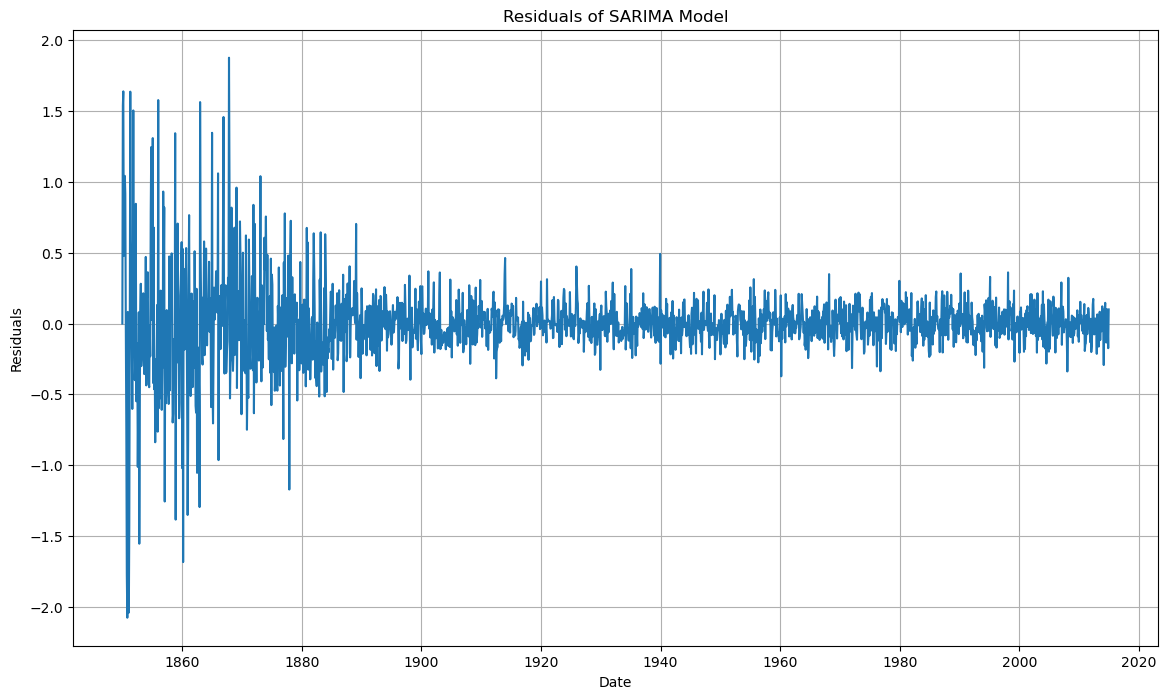

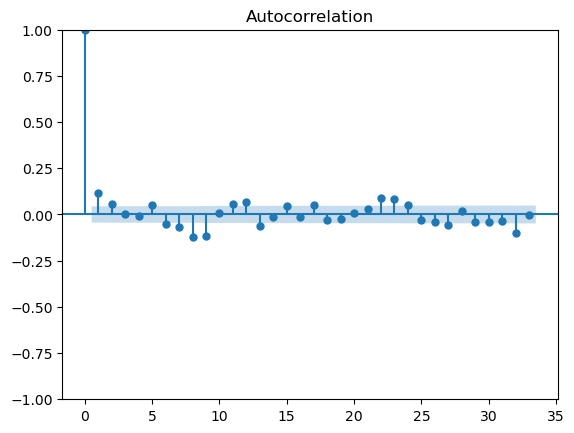

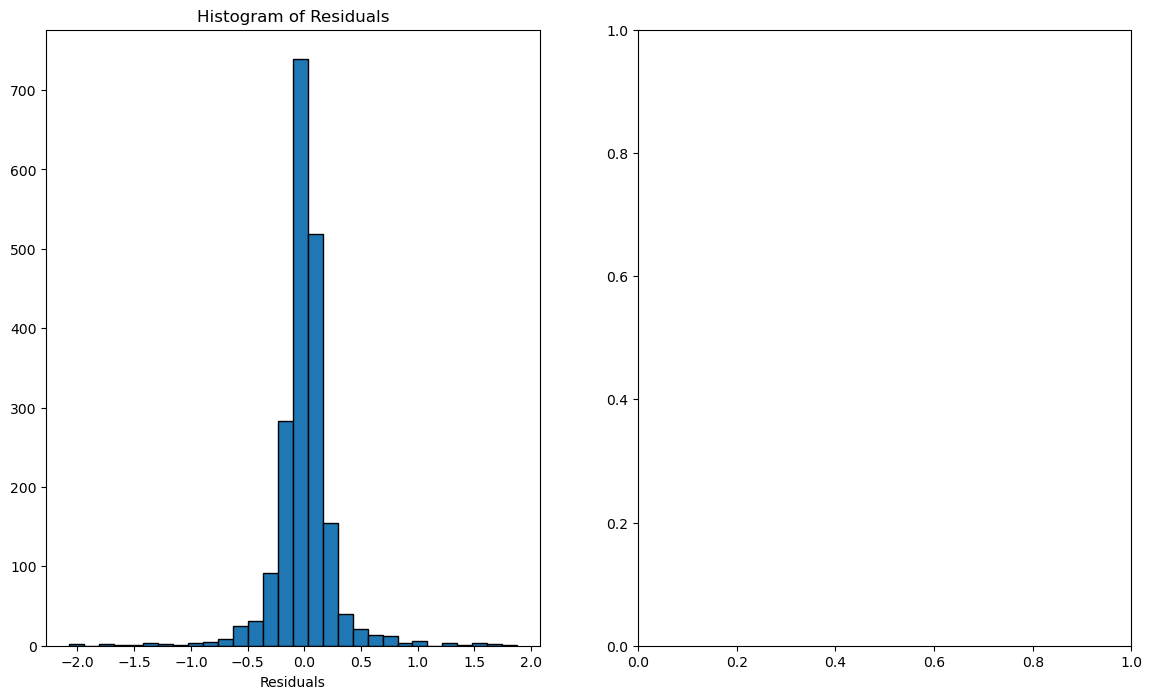

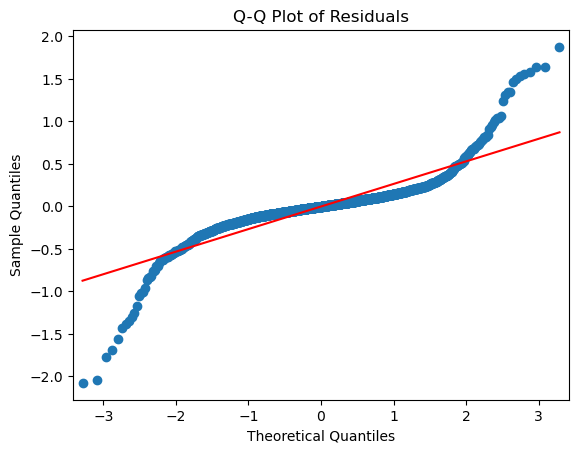

Shapiro-Wilk test for normality: W=0.7919, p-value=0.0000
Augmented Dickey-Fuller test for stationarity:
ADF Statistic: -8.0837
p-value: 0.0000
Critical Values:
   1%: -3.4337
   5%: -2.8630
   10%: -2.5676
                                      SARIMAX Results                                       
Dep. Variable:               LandAverageTemperature   No. Observations:                 1980
Model:             SARIMAX(2, 1, 2)x(0, 1, [1], 12)   Log Likelihood                  31.627
Date:                              Mon, 07 Oct 2024   AIC                            -47.254
Time:                                      19:27:51   BIC                             -2.580
Sample:                                  01-01-1850   HQIC                           -30.837
                                       - 12-01-2014                                         
Covariance Type:                                opg                                         
                         coef    std err         

In [67]:
if len(sarima_forecast_series) > 0:
    mae = mean_absolute_error(test_data, sarima_forecast_series)
    mse = mean_squared_error(test_data, sarima_forecast_series)
    rmse = np.sqrt(mse)
    r2 = r2_score(test_data, sarima_forecast_series)

    print("\nSuccess Metrics for SARIMA Model Forecast:")
    print(f"{'Mean Absolute Error (MAE)':<30}: {mae:.4f}")
    print(f"{'Mean Squared Error (MSE)':<30}: {mse:.4f}")
    print(f"{'Root Mean Squared Error (RMSE)':<30}: {rmse:.4f}")
    print(f"{'R-squared (R²)':<30}: {r2:.4f}")

    residuals = sarima_result.resid
    plt.figure(figsize=(14, 8))
    plt.plot(residuals)
    plt.xlabel('Date')
    plt.ylabel('Residuals')
    plt.title('Residuals of SARIMA Model')
    plt.grid(True)
    plt.show()
    sm.graphics.tsa.plot_acf(residuals)
    plt.show()

    plt.figure(figsize=(14, 8))
    plt.subplot(121)
    plt.hist(residuals, bins=30, edgecolor='k')
    plt.xlabel('Residuals')
    plt.title('Histogram of Residuals')

    plt.subplot(122)
    sm.qqplot(residuals, line='s')
    plt.title('Q-Q Plot of Residuals')
    plt.show()

    shapiro_test = shapiro(residuals)
    print(f"Shapiro-Wilk test for normality: W={shapiro_test[0]:.4f}, p-value={shapiro_test[1]:.4f}")

    adf_test = sm.tsa.adfuller(residuals)
    print('Augmented Dickey-Fuller test for stationarity:')
    print(f'ADF Statistic: {adf_test[0]:.4f}')
    print(f'p-value: {adf_test[1]:.4f}')
    print('Critical Values:')
    for key, value in adf_test[4].items():
        print(f'   {key}: {value:.4f}')

    print(sarima_result.summary())

else:
    print("No common dates found between validation data and forecast.")